<a href="https://colab.research.google.com/github/springboardmentor1234r/ExoHabit-AI/blob/main/Exoplanet_habitability_Milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicting the Habitability of Exoplanets Using Machine Learning

### Imports and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1. Load the data (skipping NASA comments)
df = pd.read_csv('/content/Exoplanet_habitability_dataset.csv', comment='#')

# Define target features
features = [
    'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_masse',
    'pl_dens', 'pl_insol', 'pl_eqt', 'st_teff',
    'st_met', 'st_lum', 'st_spectype'
]
df_clean = df[features].copy()
print(f"Data loaded with {df_clean.shape[0]} rows.")

Data loaded with 39212 rows.


### Data Cleaning and Imputation

In [ ]:
# Simplify star type to just the first letter (Spectral Class: O, B, A, F, G, K, M)
df_clean['st_spectype'] = df_clean['st_spectype'].str[0]

# Handle Missing Values: Use Median for numbers and Mode for categories
num_cols = df_clean.select_dtypes(include=[np.number]).columns
num_imputer = SimpleImputer(strategy='median')
df_clean[num_cols] = num_imputer.fit_transform(df_clean[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df_clean[['st_spectype']] = cat_imputer.fit_transform(df_clean[['st_spectype']])

# Handle Outliers: Clip values to 1st and 99th percentiles to avoid extreme skew
for col in num_cols:
    lower, upper = df_clean[col].quantile([0.01, 0.99])
    df_clean[col] = df_clean[col].clip(lower, upper)

print("Data cleaning and outlier clipping complete.")

Data cleaning and outlier clipping complete.


### Feature Engineering

In [ ]:
# A. Habitability Score Index (Earth Similarity Index)
def calculate_hab_score(row):
    # Reference Earth values: Radius=1.0, Density=5.51, Temp=255K, Insolation=1.0
    s_radius = np.exp(-abs(row['pl_rade'] - 1.0) / 1.0)
    s_density = np.exp(-abs(row['pl_dens'] - 5.51) / 5.0)
    s_temp = np.exp(-abs(row['pl_eqt'] - 255.0) / 50.0)
    s_insol = np.exp(-abs(row['pl_insol'] - 1.0) / 1.0)

    return (s_radius * s_density * s_temp * s_insol)**(1/4)

# B. Stellar Compatibility Index (Similarity to our Sun)
def calculate_stellar_index(row):
    # Sun Reference: Teff=5778K, Lum=0.0 (log scale), Met=0.0 (dex)
    t_sim = np.exp(-abs(row['st_teff'] - 5778) / 1000.0)
    l_sim = np.exp(-abs(row['st_lum'] - 0.0) / 1.0)
    m_sim = np.exp(-abs(row['st_met'] - 0.0) / 0.5)

    return (t_sim * l_sim * m_sim)**(1/3)

# Apply the functions
df_clean['habitability_score'] = df_clean.apply(calculate_hab_score, axis=1)
df_clean['stellar_compatibility'] = df_clean.apply(calculate_stellar_index, axis=1)

print("Feature Engineering complete.")

Feature Engineering complete.


### Encoding and Scaling

In [ ]:
# 4. Encoding: One-Hot Encode the Star Type
df_clean = pd.get_dummies(df_clean, columns=['st_spectype'], prefix='star_type')

# 5. Normalize Numerical Features using StandardScaler
numerical_features = df_clean.select_dtypes(include=[np.number]).columns
sc = StandardScaler()
df_clean[numerical_features] = sc.fit_transform(df_clean[numerical_features])

# 6. Validate Data Quality
print("Data Preprocessing Complete.")
df_clean.describe()

Data Preprocessing Complete.


,pl_orbper,pl_orbsmax,pl_rade,pl_masse,pl_dens,pl_insol,pl_eqt,st_teff,st_met,st_lum,habitability_score,stellar_compatibility
count,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04,3.921200e+04
mean,-2.609358e-17,2.899287e-18,5.798574e-17,-1.681586e-16,3.189216e-16,9.277718e-17,-2.725330e-16,-1.072736e-16,-3.479144e-17,7.248217e-17,6.523396e-18,2.152721e-16
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-2.316347e-01,-3.581030e-01,-7.600567e-01,-6.302041e-01,-1.798117e+00,-4.994493e-01,-2.077807e+00,-3.017004e+00,-3.210757e+00,-5.081792e+00,-1.705627e-01,-3.659254e+00
25%,-2.205547e-01,-2.580585e-01,-4.180122e-01,-1.442736e-01,-1.106022e-01,-2.574348e-01,-1.259083e-01,-4.201004e-01,-2.813324e-01,5.406754e-02,-1.705627e-01,-4.995244e-01
50%,-2.050733e-01,-2.400974e-01,-2.908806e-01,-1.442736e-01,-1.106022e-01,-2.574348e-01,-1.259083e-01,2.191927e-01,6.755301e-02,5.406754e-02,-1.705627e-01,2.131083e-01
75%,-1.682291e-01,-2.215749e-01,-1.682894e-01,-1.442736e-01,-1.106022e-01,-2.574348e-01,-1.259083e-01,6.496787e-01,3.254249e-01,5.406754e-02,-1.705627e-01,7.978785e-01
max,7.781522e+00,6.771609e+00,4.348505e+00,8.056520e+00,7.788425e+00,6.425692e+00,4.062956e+00,1.819571e+00,2.509751e+00,3.048261e+00,1.379961e+01,1.500008e+00


### Export and Visualization

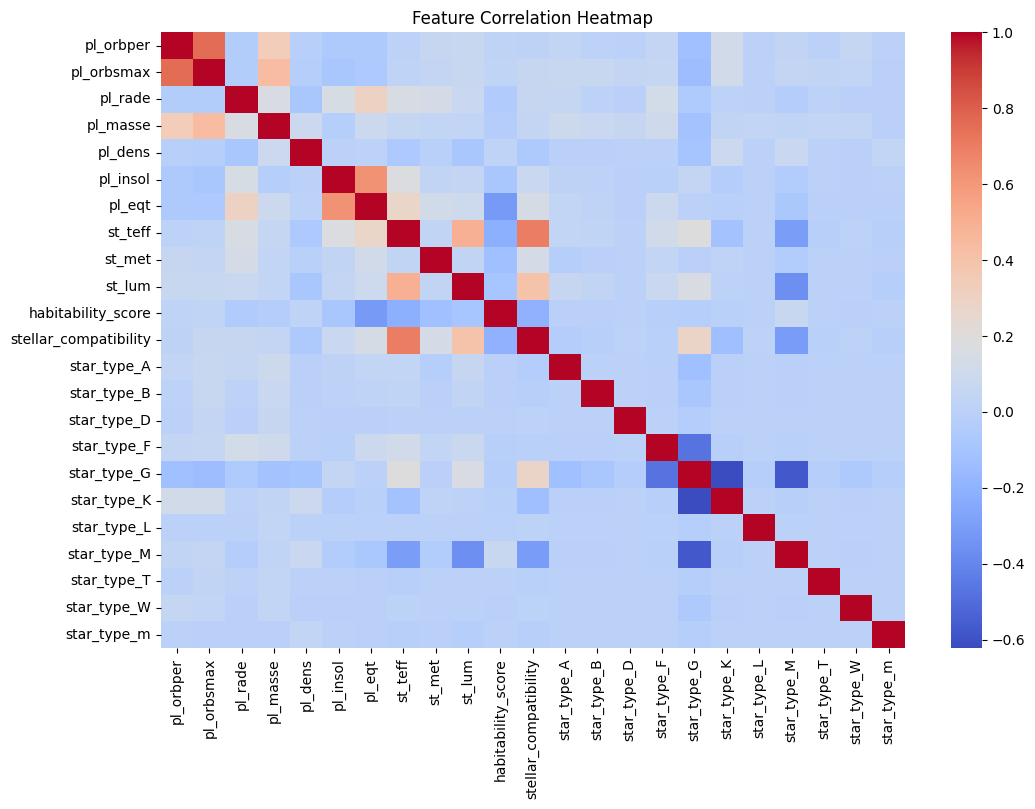

New Columns: ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_masse', 'pl_dens', 'pl_insol', 'pl_eqt', 'st_teff', 'st_met', 'st_lum', 'habitability_score', 'stellar_compatibility', 'star_type_A', 'star_type_B', 'star_type_D', 'star_type_F', 'star_type_G', 'star_type_K', 'star_type_L', 'star_type_M', 'star_type_T', 'star_type_W', 'star_type_m']


In [ ]:
# Save the processed data
df_clean.to_csv('processed_habitability_data.csv', index=False)

# 7. Visualization: Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Verification
processed_df = pd.read_csv('processed_habitability_data.csv')
print("New Columns:", processed_df.columns.tolist())